<a href="https://colab.research.google.com/github/rajibmondal/Projects.NLP/blob/master/NLP_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
from fastai.text import *
from fastai import *
bs = 128

In [55]:
data_dir = '/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets'

path = Path(data_dir)

df = pd.read_csv(path/'clean_train.csv')
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [141]:
path.ls()
# df.shape

[PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/train.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/test.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/clean_train.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/lm_databunch'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/tmp_lm'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/NLP with Disaster Tweets.ipynb'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/data_lm.pkl'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/data1_lm.pkl'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/models'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/clean

In [0]:
# data_lm = (TextList.from_csv(path,'clean_train.csv')
#            #Inputs: all the text files in path
#             .filter_by_csv(include=['clean_train.csv']) 
#            #We may have other temp folders that contain text files so we only keep what's in train and test
#             .split_by_rand_pct(0.1)
#            #We randomly split and keep 10% (10,000 reviews) for validation
#             .label_for_lm()           
#            #We want to do a language model so we label accordingly
#             .databunch(bs=bs))
# data_lm.save('data1_lm.pkl')

In [0]:
# # data_lm = (TextList.from_folder(path).filter_by_folder(include=['train','test'])
# # .split_by_rand_pct(0.1, seed=42).label_for_lm().databunch(bs=bs, num_workers=1))

# data_clas = (TextList
#            .from_csv(path, 'clean_train.csv', cols='text')
#            #Where are the text? Column 'text' of texts.csv
#            .split_by_rand_pct()
#            #How to split it? Randomly with the default 20% in valid
#            .label_from_df(cols='target')
#            #Label it for a language model
#            .databunch(bs=bs))
#            #Finally we convert to a DataBunch

# data_clas.show_batch()

In [97]:
data = (TextList
           .from_csv(path, 'clean_train.csv', cols='text')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()#from_df(cols='target')
           #Label it for a language model
           .databunch(bs=bs))
           #Finally we convert to a DataBunch

In [98]:
data.show_batch()

idx,text
0,xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk xxunk xxmaj colorado xxmaj springs areas xxbos xxmaj there 's an emergency evacuation happening now in the building across the street xxbos xxmaj three people died from the heat wave so far
1,xxmaj marker 31 xxmaj south xxmaj xxunk xxmaj xxunk xxmaj vehicle xxmaj accident xxmaj xxunk xxmaj closed at 8 / 6 xxunk xxup pm xxbos xxup rt xxunk : xxmaj sleeping xxunk double your risk of a car accident http : / / t.co / xxunk xxbos ' xxmaj by accident ' they knew what was gon happen https : / / t.co / xxunk xxbos xxmaj traffic accident n
2,school kick off was great . i want to thank everyone for making it possible . xxmaj what a great night . xxbos ' xxmaj the first man gets the xxunk the second man gets the shell . ' xxmaj xxunk xxmaj xxunk xxbos xxmaj anyone need a p / u tonight ? i play xxmaj hybrid xxmaj slayer xxunk xxup xxunk . xxup xxunk xxunk xxunk xxunk xxup xxunk
3,/ / t.co / xxunk xxbos xxmaj pakistan air ambulance helicopter crash kills nine http : / / t.co / xxunk xxbos xxup xxunk : xxup ny xxunk petition for $ 17 per hour xxunk xxunk http : / / t.co / xxunk # ems # xxunk # ambulance xxbos http : / / t.co / xxunk xxmaj twelve feared killed in xxmaj pakistani air ambulance helicopter crash http :
4,... http : / / t.co / xxunk via @change xxbos xxunk xxunk of annihilation xxbos : xxunk : : xxmaj xxunk 3 : : xxmaj xxunk xxmaj annihilation : : http : / / t.co / xxunk via @youtube xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj


In [0]:
data.save('data1_lm.pkl')

In [62]:
path.ls()

[PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/train.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/test.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/clean_train.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/lm_databunch'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/tmp_lm'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/NLP with Disaster Tweets.ipynb'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/data_lm.pkl'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/data1_lm.pkl'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/models'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/clean

In [0]:
data_lm = load_data(path, 'data1_lm.pkl', bs=bs)

In [64]:
data_lm.show_batch()

idx,text
0,orders in xxmaj california xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # xxunk xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj
1,/ t.co / xxunk xxbos xxunk xxmaj live xxmaj accident xxmaj xxunk xxbos xxup i-77 xxmaj mile xxmaj xxunk 31 xxmaj south xxmaj xxunk xxmaj xxunk xxmaj vehicle xxmaj accident xxmaj xxunk xxmaj closed at 8 / 6 xxunk xxup pm xxbos xxup rt xxunk : xxmaj sleeping xxunk double your risk of a car accident http : / / t.co / xxunk xxbos ' xxmaj by accident ' they
2,https : / / t.co / xxunk xxbos ' xxmaj remembering that you are going to die is the best way i know to avoid the trap of thinking you have something to lose . ' xxup ûò xxmaj steve xxmaj jobs xxbos xxmaj tried orange aftershock today . xxmaj my life will never be the same xxbos xxunk i love you xxunk xxbos xxmaj aftershock https : / /
3,/ t.co / xxunk # til_now # xxup xxunk xxbos http : / / t.co / xxunk xxmaj twelve feared killed in xxmaj pakistani air ambulance helicopter crash http : / / t.co / xxunk xxbos xxunk waiting for an ambulance xxbos xxunk you ok ? xxmaj need a ambulance . xxmaj xxunk that was good ! http : / / t.co / xxunk xxbos xxmaj pakistan air ambulance helicopter
4,: xxmaj xxunk 3 : : xxmaj xxunk xxmaj annihilation : : http : / / t.co / xxunk via @youtube xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse ... https : / / t.co / xxunk via @change xxbos xxup u.s xxmaj national xxmaj park xxmaj


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


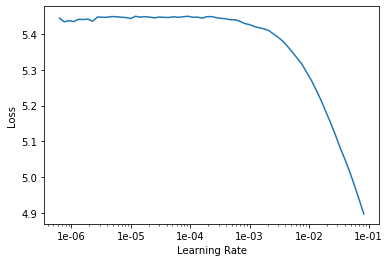

In [67]:
learn.recorder.plot(skip_end=25)

In [71]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.029464,3.159175,0.452031,00:05


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [75]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.591631,3.113550,0.458728,00:07
1,2.521553,3.062801,0.466451,00:07
2,2.427628,3.017893,0.478504,00:07
3,2.336658,3.038552,0.478438,00:07
4,2.183128,3.066031,0.484263,00:07
5,2.043673,3.107359,0.483058,00:07
6,1.892451,3.183647,0.483549,00:07
7,1.752209,3.219073,0.482188,00:07
8,1.654099,3.239048,0.481384,00:07
9,1.570394,3.243961,0.481763,00:07


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "there is fire"
N_WORDS = 40
N_SENTENCES = 2

In [79]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

there is fire on top of burning buildings and security acres . xxbos Police Officer Wounded Suspect Dead After Exchanging Shots - http : / / t.co / THOYHRHKFJ Fan Army #
there is fire between the two buildings for 2 buildings . There s buildings on fire that save all buildings and buildings on fire . xxbos Blamed for Missing Cree veterans in West Bank Windstorm


In [0]:
learn.save_encoder('fine_tuned_enc')

In [107]:
path.ls()

[PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/train.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/test.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/clean_train.csv'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/lm_databunch'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/tmp_lm'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/NLP with Disaster Tweets.ipynb'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/data_lm.pkl'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/data1_lm.pkl'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/models'),
 PosixPath('/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets/clean

In [36]:
# data_class = (TextList
#            .from_csv(path, 'clean_train.csv', cols='text')
#            #Where are the text? Column 'text' of texts.csv
#            .split_by_rand_pct()
#            #How to split it? Randomly with the default 20% in valid
#            .label_from_df(cols='target')
#            #Label it for a language model
#            .databunch(bs=bs))
#            #Finally we convert to a DataBunch

###Classifier

In [0]:
data_dir = '/content/drive/My Drive/NLP/NLP_DATA/ NLP with Disaster Tweets'

path = Path(data_dir)

In [114]:
# data_lm = (TextList.from_folder(path).filter_by_folder(include=['train','test'])
# .split_by_rand_pct(0.1, seed=42).label_for_lm().databunch(bs=bs, num_workers=1))

data_clas = (TextList
           .from_csv(path1, 'clean_train.csv', cols='text')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_from_df(cols='target')
           #Label it for a language model
           .databunch(bs=bs))
           #Finally we convert to a DataBunch


data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [116]:
data_clas.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos xxup info xxup r. xxup curfew xxup in xxup xxunk xxup until xxunk xxup xxunk xxup xxunk xxup xxunk 5 & & xxup xxunk 6 xxup xxunk . xxup xxunk : xxunk / 5 . xxup exp xxup xxunk xxup xxunk . xxup xxunk 05 . xxup xxunk . xxup xxunk : 10 . xxup xxunk : xxunk .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,1


In [0]:
data_clas.vocab.itos = data_lm.vocab.itos

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

In [145]:
learn.load_encoder('fine_tuned_enc')

RuntimeError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


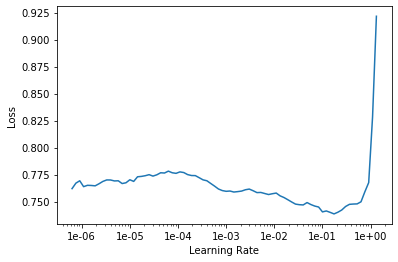

In [123]:
learn.lr_find()
learn.recorder.plot()

In [127]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.662938,0.650591,0.623522,00:03


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [131]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.650373,0.653224,0.591327,00:04


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [134]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.643979,0.680604,0.591327,00:06


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [137]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.617908,0.591076,0.676084,00:07
1,0.594383,0.575866,0.699080,00:07
